In [1]:
using Pkg
Pkg.activate("my_environment", shared=true)
using Statistics
using DataFrames
using Queryverse
using VegaLite
using MLJ
using ShapML




 Activating environment at `~/.julia/environments/my_environment/Project.toml`


## Objective

The objective is to build a regression model which predicts houseprice from several housing variables.

## Data Description 

Area and Prices are quantitative variables measured in square-feet and dollars respectively.  Garage, FirePlace and Baths refers to the number of this items in a specific house.  City is a qualitative variable indicating one of 3 different cities.  All remaining variable indicate the presence (1) of absence (0) of that feature.  

In [2]:
# Load the data and show a preview
houseprice = Queryverse.load("/home/chigball/Data/houseprice.csv") |> DataFrame
describe(houseprice)

16×8 DataFrame. Omitted printing of 1 columns
│ Row │ variable     │ mean     │ min   │ median  │ max   │ nunique │ nmissing │
│     │ Symbol       │ Float64  │ Int64 │ Float64 │ Int64 │ Nothing │ Nothing  │
├─────┼──────────────┼──────────┼───────┼─────────┼───────┼─────────┼──────────┤
│ 1   │ Area         │ 124.93   │ 1     │ 125.0   │ 249   │         │          │
│ 2   │ Garage       │ 2.00129  │ 1     │ 2.0     │ 3     │         │          │
│ 3   │ FirePlace    │ 2.0034   │ 0     │ 2.0     │ 4     │         │          │
│ 4   │ Baths        │ 2.99807  │ 1     │ 3.0     │ 5     │         │          │
│ 5   │ WhiteMarble  │ 0.332992 │ 0     │ 0.0     │ 1     │         │          │
│ 6   │ BlackMarble  │ 0.33269  │ 0     │ 0.0     │ 1     │         │          │
│ 7   │ IndianMarble │ 0.334318 │ 0     │ 0.0     │ 1     │         │          │
│ 8   │ Floors       │ 0.499386 │ 0     │ 0.0     │ 1     │         │          │
│ 9   │ City         │ 2.00094  │ 1     │ 2.0     │ 3     │         │          │
│ 10  │ Solar        │ 0.498694 │ 0     │ 0.0     │ 1     │         │          │
│ 11  │ Electric     │ 0.50065  │ 0     │ 1.0     │ 1     │         │          │
│ 12  │ Fiber        │ 0.500468 │ 0     │ 1.0     │ 1     │         │          │
│ 13  │ GlassDoors   │ 0.49987  │ 0     │ 0.0     │ 1     │         │          │
│ 14  │ SwimingPool  │ 0.500436 │ 0     │ 1.0     │ 1     │         │          │
│ 15  │ Garden       │ 0.501646 │ 0     │ 1.0     │ 1     │         │          │
│ 16  │ Prices       │ 42050.1  │ 7725  │ 41850.0 │ 77975 │         │          │

## Data Exploraton 

Data was manipulated to investigate one of three things:

1. Distribution of house price
2. How area affects the average house price
3. What house price variable contribute to house price

In [3]:
# Dicts for code manipulation 
D1 = Dict("001" => "Indian", "010" => "Black", "100" => "White")
D2 = Dict(0 => "No", 1 => "Yes")

# Manipulate data for data exploration
houseprice_ex = houseprice |> 
@mutate(MarbleType = string(_.WhiteMarble) * string(_.BlackMarble) * string(_.IndianMarble)) |> 
@mutate(MarbleType = D1[_.MarbleType]) |>
@mutate(Floors = D2[_.Floors]) |> # Floors
@mutate(Solar = D2[_.Solar]) |> # Solar
@mutate(Electric = D2[_.Electric]) |> # Electric
@mutate(Fiber = D2[_.Fiber]) |> # Fiber
@mutate(GlassDoors = D2[_.GlassDoors]) |> # GlassDoors
@mutate(SwimingPool = D2[_.SwimingPool]) |> # SwimingPool
@mutate(Garden = D2[_.Garden]) |> # Garden
@select(1:4, 17, 8:16) |> DataFrame

# Code creates expressions for aggregation and plotting of dependent variable against average price 
function aggprice(v::Symbol, x::String)
:(
df = houseprice_ex |> 
@groupby(_.$v) |> 
@map({$v = key(_), Avg_Price = mean(_.Prices)}) |> 
@orderby(_.$v) |> 
@vlplot(
mark = :bar,
x = $x,
y = {"Avg_Price:q", title = "Average Price"}
)  
)
end

# Data plots of dependent variables vs price
Garage = eval(aggprice(:Garage, "Garage:n")) # Garage y
FirePlace = eval(aggprice(:FirePlace, "FirePlace:n")) # FirePlace y
Baths = eval(aggprice(:Baths, "Baths:n")) # Baths y
MarbleType = eval(aggprice(:MarbleType, "MarbleType:n")) # MarbleType yy
Floors = eval(aggprice(:Floors, "Floors:n")) # Floors yy
City = eval(aggprice(:City, "City:n")) # City y
Solar = eval(aggprice(:Solar, "Solar:n")) # Solar n
Electric = eval(aggprice(:Electric, "Electric:n")) # Electric 0.5y
Fiber = eval(aggprice(:Fiber, "Fiber:n")) # Fiber yy
GlassDoors = eval(aggprice(:GlassDoors, "GlassDoors:n")) # GlassDoors 0.5y
SwimingPool = eval(aggprice(:SwimingPool, "SwimingPool:n")) # SwimingPool n
Garden = eval(aggprice(:Garden, "Garden:n")); # Garden n

# Average House Price by Area Range
ahp = houseprice_ex |> 
@take(20000) |>
@vlplot(
mark = {:line, point = true},
x = {"Area:o", bin={maxbins=20}, title = "Area Range"},
y = {"mean(Prices)", scale = {zero = false}, title = "Average House Price"},
height = 200,
width = 400,
title = "Average House Price by Area Range"
)


# House Price Density Plot
houseprice_dp = houseprice_ex |> 
@take(10000) |>
@vlplot(
mark = :area, # It's an area plot
transform = [{density = "Prices"}], # For counts add in : counts = true
x = {"value:q", title = "House Price"},
y = {"density:q"},  # Density variable created
width = 400,
title = "House Price Density Plot"
);



The distribution of house price is generally bell shaped, with a high number house-prices in the 35,000 to 40,000 range.

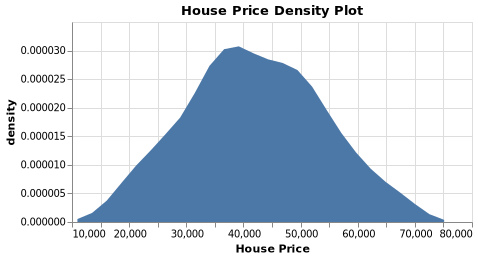

In [4]:
houseprice_dp

Average house prices generally increase with area range, however that trend is broken in the range 80-120 sqft as well as 180-200 sqft. 

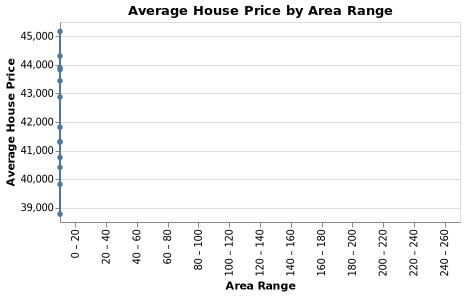

In [5]:
ahp 

Having white marble type and a fiber connection tends to be a strong predictor of price. Variables like Garage, FirePlace, Baths and Floors which increase with Area also tend to predict higher prices. Non predictors of price seem to includes features like Solar SwimmingPool and Garden.

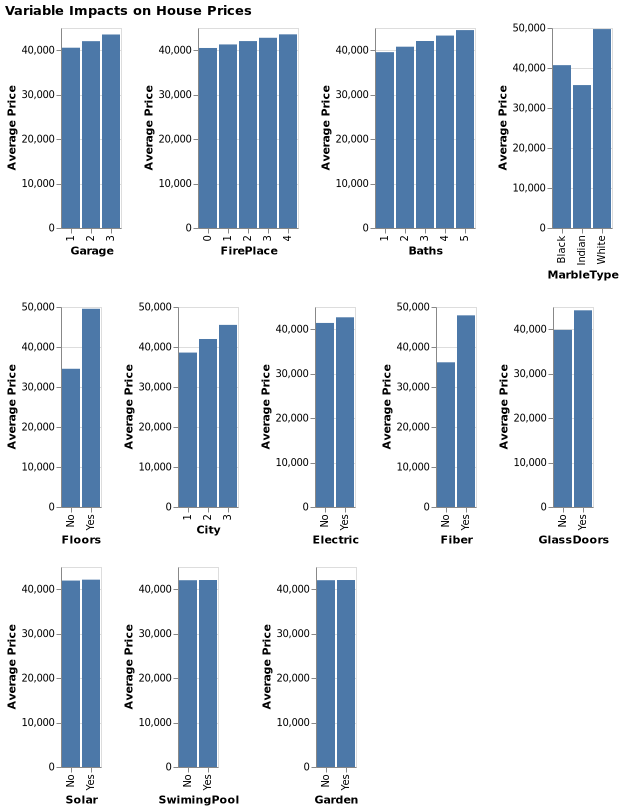

In [6]:
@vlplot(title="Variable Impacts on House Prices") + 
[[Garage FirePlace Baths MarbleType] ; [Floors City Electric Fiber GlassDoors] ; [Solar SwimingPool Garden]] 


## Model Building
The data was split into a training and testing set (70/30).  The data science pipeline requires converting variables into a continuous type, then fitting a EvoTree Regressor model to predict house prices, using a max_dept of 8.  


In [7]:
# Filter data for useful variables and convert Prices to float
houseprice_mod = houseprice |>@select(-:Solar, -:SwimingPool, -:Garden) |> @mutate(Prices = float(_.Prices)) |> DataFrame;

# Select X and y for modeling
X = houseprice_mod |> @select(-:Prices) |> DataFrame
y = houseprice_mod.Prices

# Create an index for model and validation sets
m, v = partition(eachindex(y), 0.7, shuffle=true);

# Create model/training sets
Xm = X[m,:]
ym = y[m]

# Create validation/testing sets
Xv = X[v,:]
yv = y[v]

# load EvoTreeRegressor model
@load EvoTreeRegressor pkg="EvoTrees"

# Create pipeline that converts inputs into continous and fits an EvoTreeRegressor
pipe = @pipeline(
X -> coerce(X, Count => Continuous),
EvoTreeRegressor(max_depth = 8),
prediction_type=:deterministic
);

# Fit machine
mach = machine(pipe, Xm, ym);
fit!(mach);

pipe

┌ Info: Training Machine{Pipeline353} @945.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Training Machine{EvoTreeRegressor{Float32,…}} @267.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Pipeline353(
    evo_tree_regressor = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0f0,
            γ = 0.0f0,
            η = 0.1f0,
            max_depth = 8,
            min_weight = 1.0f0,
            rowsample = 1.0f0,
            colsample = 1.0f0,
            nbins = 64,
            α = 0.5f0,
            metric = :mse,
            seed = 444)) @278

## Cross Validation

The number of rounds of training (nrounds) was plotted on a learning curve.  After about 120 rounds there are diminishing returns for a low rms error, as a result the original model will be retrained with nrounds=128 rather than nrounds=10.  

In [8]:
# Function to plot learning curves
function plot_lc(curve::NamedTuple, measure::String)
  
  # Create a dataframe from data
  df = DataFrame(parameter_values = curve.parameter_values, measurements = curve.measurements)
  
  # Use vlplot to plot data  
  @vlplot(
    data = df,
    mark = {:line, tooltip = true, point = true},
    x = {"parameter_values:q", title = curve.parameter_name},
    y = {"measurements:q", title = measure},
    title = "Learning Curve",
    height = 250,
    width = 260
  )  
end

# Generate learning curve
r = range(pipe, :(evo_tree_regressor.nrounds); values = 1:20:130)
curve = learning_curve(mach; range=r, resampling=CV(), measure=rms)



┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @663.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 7 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/6MZ7C/src/tuned_models.jl:554
Evaluating over 7 metamodels: 100%[=========================] Time: 0:03:22


(parameter_name = "evo_tree_regressor.nrounds",
 parameter_scale = :none,
 parameter_values = [1, 21, 41, 61, 81, 101, 121],
 measurements = [10965.985623600527, 2166.116583103332, 751.2958321330062, 340.56739711881994, 246.73780094914056, 230.2544093161579, 225.76288485595623],)

A sufficient number of rounds is needed to achieve rms > 300, as indicated by the chart below

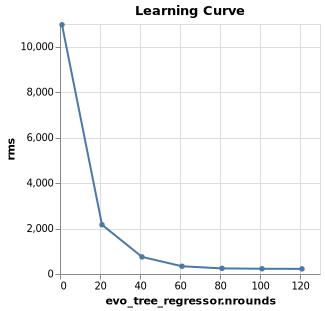

In [9]:
# Plot learning curve
p1 = plot_lc(curve, "rms")

In [10]:
# Retrain model at nrounds = 128
pipe.evo_tree_regressor.nrounds = 128
mach = machine(pipe, Xm, ym);
fit!(mach);

┌ Info: Training Machine{Pipeline353} @495.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Training Machine{EvoTreeRegressor{Float32,…}} @617.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


## Model Evaluation 

Evaluation was done using the metrics rms and mae and a 70% shuffled resampling.  An error of <250 as achieved for both metrics.  

In [11]:
# Model Evaluation on test data
yp = collect(predict(mach, Xv))
RMS = round(rms(yp, yv), digits = 3) 
COR = round(Statistics.cor(yp, yv), digits = 3) 

# Model Evaluation
evaluate!(mach, 
  resampling=Holdout(fraction_train=0.7, shuffle=true, rng=1234),
  measures=[rms, mae],
  verbosity = 0
)


┌───────────┬───────────────┬────────────┐
│ _.measure │ _.measurement │ _.per_fold │
├───────────┼───────────────┼────────────┤
│ rms       │ 233.0         │ [233.0]    │
│ mae       │ 187.0         │ [187.0]    │
└───────────┴───────────────┴────────────┘
_.per_observation = [missing, missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [12]:
"A rms error of $(RMS) was also achieved for the test set"

"A rms error of 221.364 was also achieved for the test set"

## Variable Importance

The chart below ranks variables in types of contribuion to the model, under the Shapley framework.  Interestingly, Floors, Fiber and WhiteMarble are the best predictors of house price.

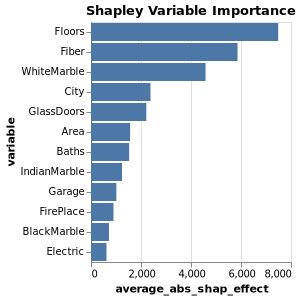

In [13]:
# Get a sample of values
explain  = Xm |> @take(5000) |> DataFrame;

# Prediction function to dataframe
function predict_function(model, data)
  data_pred = DataFrame(y_pred = predict(model, data))
  return data_pred
end


# Compute stochastic Shapley values.
data_shap = ShapML.shap(explain = explain,
                        model = mach,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 1
                        );

# Calculate Average Absolute Shapley Effect
shap_df = data_shap |> 
@select(:index, :feature_name, :shap_effect) |>
@mutate(abs_shap_effect = abs(_.shap_effect)) |>
@groupby(_.feature_name) |>
@map({variable = key(_), average_abs_shap_effect = mean(_.abs_shap_effect)}) |>
@mutate(average_abs_shap_effect = round(_.average_abs_shap_effect, digits = 2)) |>
@orderby_descending(_.average_abs_shap_effect) |> DataFrame;

# Plot the results
@vlplot(
  data = shap_df,
  mark = :bar,
  y = {"variable:n", sort = "-x"},
  x = "average_abs_shap_effect:q",
  title = "Shapley Variable Importance"
)